
# Online Retail — Pré-processamento, EDA e Clusterização (Ward)

Este notebook conduz um fluxo completo de pré processamento e clusterização para o dataset **Online Retail (UCI)**:
1) **Carregamento e checagens iniciais**  
2) **Limpeza e engenharia de variáveis** (flags de cancelamento/ajuste, valor por linha, etc.)  
3) **Análise exploratória** com foco em `StockCode` (produtos)  
6) **Export dos resultados - salvando dataset tratado para consumo nos algoritmos de clustering**

> Observações
> - Os métodos de clustering normalmente usam métricas que envolvem distância e minimiza a variância intra-cluster; por isso precisamos **padronizar** as features.  
> - O dataset contém registros **administrativos** (ex.: *Adjust bad debt*, *Bank charges*, **InvoiceNo** iniciando em `A` para ajustes e `C` para cancelamentos). Mantemos **flags** para transparência e **filtramos** para análises comerciais.

Link de acesso ao dataset: https://archive.ics.uci.edu/dataset/352/online+retail

In [1]:
#Import necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
import os
import sys
import pandas as pd
from time import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

notebook_dir = os.getcwd()
src_path = os.path.abspath(os.path.join(notebook_dir, '..', 'src'))
sys.path.append(src_path)
from dbscan import DBSCAN
from kmeans import KMeans
from kmedoids import KMedoids
from wardmethod import WardMethod
from expectationmaximization import ExpectationMaximization
import distance_metrics
from evaluationmetrics import EvaluationMetrics
from func_auxiliar import plot_algorithm_all_metrics, calculate_clustering_metrics, generate_synthetic_blobs

In [2]:

FILE_PATH = r"/root/jane-oliveira/tcc-git/clustering-client-segmentation-tcc/data/DatasetRaw/online_retail/Online Retail.xlsx"

# Leitura do Excel
df = pd.read_excel(FILE_PATH)

# Uniformização de nomes esperados
expected_cols = ['InvoiceNo','StockCode','Description','Quantity','InvoiceDate','UnitPrice','CustomerID','Country']
df = df[expected_cols]

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
# Remoção de linhas com CustomerID nulo | somente clientes identificados serão considerados
df = df.dropna(subset=['CustomerID'])

In [4]:
# Remoção de linhas com Quantity menor ou igual a zero | somente compras válidas serão consideradas cancelamentos não são consideradas
df = df[df['Quantity'] > 0]

In [5]:
# Remoção de linhas com UnitPrice menor ou igual a zero | brindes e ajustes não devem ser considerados
df = df[df['UnitPrice'] > 0]

In [6]:
#Criando coluna TotalPrice
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [7]:
# Remoção de linhas duplicadas
df = df.drop_duplicates()

In [8]:
# Conversão da coluna InvoiceDate para o tipo datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [9]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [10]:
# Data de referência (snapshot) = 1 dia após a última compra registrada
snapshot_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)

# Agrupa por cliente
rfm = (
    df
    .groupby("CustomerID")
    .agg(
        Recency=("InvoiceDate", lambda x: (snapshot_date - x.max()).days),
        Frequency=("InvoiceNo", "nunique"),   # contagem de invoices distintos
        Monetary=("Quantity", lambda x: (x * df.loc[x.index, "UnitPrice"]).sum())
    )
)



In [11]:
scaler = MinMaxScaler()
rfm_scaled = scaler.fit_transform(rfm)

In [12]:
X = pd.DataFrame(
    rfm_scaled,
    index=rfm.index,
    columns=["Recency_scaled", "Frequency_scaled", "Monetary_scaled"]
)

### Algoritmo: Kmeans

In [13]:
metrics = ['euclidean_distance', 'manhattan_distance', 'cosine_distance', 'mahalanobis_distance', 'jensen_shannon_distance']


In [14]:
results_kmeans = []
plots_kmeans = {}
# instaciando o KMeans
for metric_name in metrics:
    kmeans = KMeans(k=3, max_iterations=7000, metric_name=metric_name)
    t0 = time()
    centroids_kmeans, clusters_kmeans = kmeans.fit(X)
    runtime_kmeans = time() - t0
    results_kmeans.append(calculate_clustering_metrics(algorithm_name="Kmeans", metric_name=metric_name, runtime=runtime_kmeans, X=X, labels=clusters_kmeans))
    plots_kmeans[metric_name] = {
        "X": X,
        "labels": clusters_kmeans,
        "model": kmeans
    }

Convergiu na iteração 21
Convergiu na iteração 25
Convergiu na iteração 21
Convergiu na iteração 17
Convergiu na iteração 23


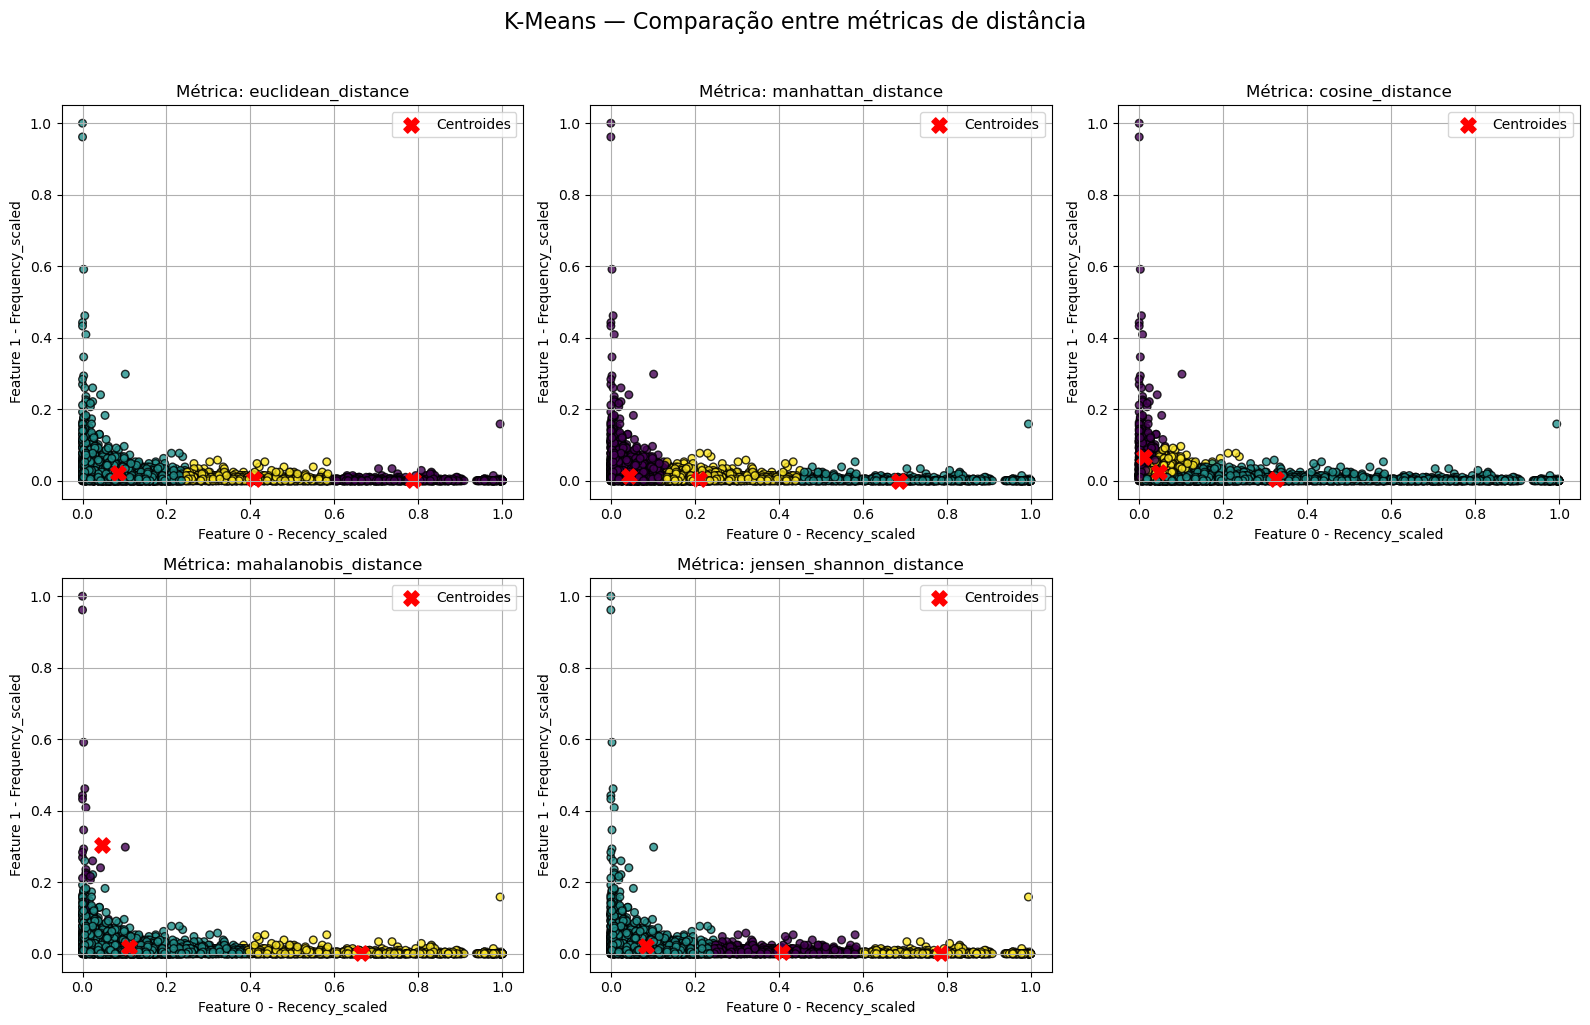

In [15]:
plot_algorithm_all_metrics(plots_kmeans, "K-Means", x_index=0, y_index=1, feature_names=X.columns.tolist())

In [16]:
#results_kmeans.pop()
df_results_kmeans = pd.DataFrame(results_kmeans)
df_results_kmeans

,algorithm,internal_metric,n_clusters_found,runtime_sec,sse_euclidean,silhouette,davies_bouldin,calinski_harabasz
0,Kmeans,euclidean_distance,3,0.864938,40.871909,0.644845,0.505071,14919.978650
1,Kmeans,manhattan_distance,3,1.291828,47.600360,0.557716,0.586895,12504.613414
2,Kmeans,cosine_distance,3,1.726942,245.702018,-0.089795,1.377482,674.958866
3,Kmeans,mahalanobis_distance,3,1.024844,70.030733,0.701699,0.825255,7805.234166
4,Kmeans,jensen_shannon_distance,3,1.001000,40.871909,0.644845,0.505071,14919.978650


### Algoritmo: Kmedoids

In [ ]:
results_kmedoids = []
plots_kmedoids = {}
# instaciando o KMedoids
for metric_name in metrics:
    kmedoids = KMedoids(k=3, max_iterations=7000, metric_name=metric_name)
    t0 = time()
    centroids_kmedoids, clusters_kmedoids = kmedoids.fit(X)
    runtime_kmedoids = time() - t0
    results_kmedoids.append(calculate_clustering_metrics(algorithm_name="KMedoids", metric_name=metric_name, runtime=runtime_kmedoids, X=X, labels=clusters_kmedoids))
    plots_kmedoids[metric_name] = {
        "X": X,
        "labels": clusters_kmedoids,
        "model": kmedoids
    }
    print(f"KMedoids com métrica {metric_name} finalizado.")

K-Medoids convergiu na iteração 12
KMedoids com métrica euclidean_distance finalizado.
K-Medoids convergiu na iteração 9
KMedoids com métrica manhattan_distance finalizado.


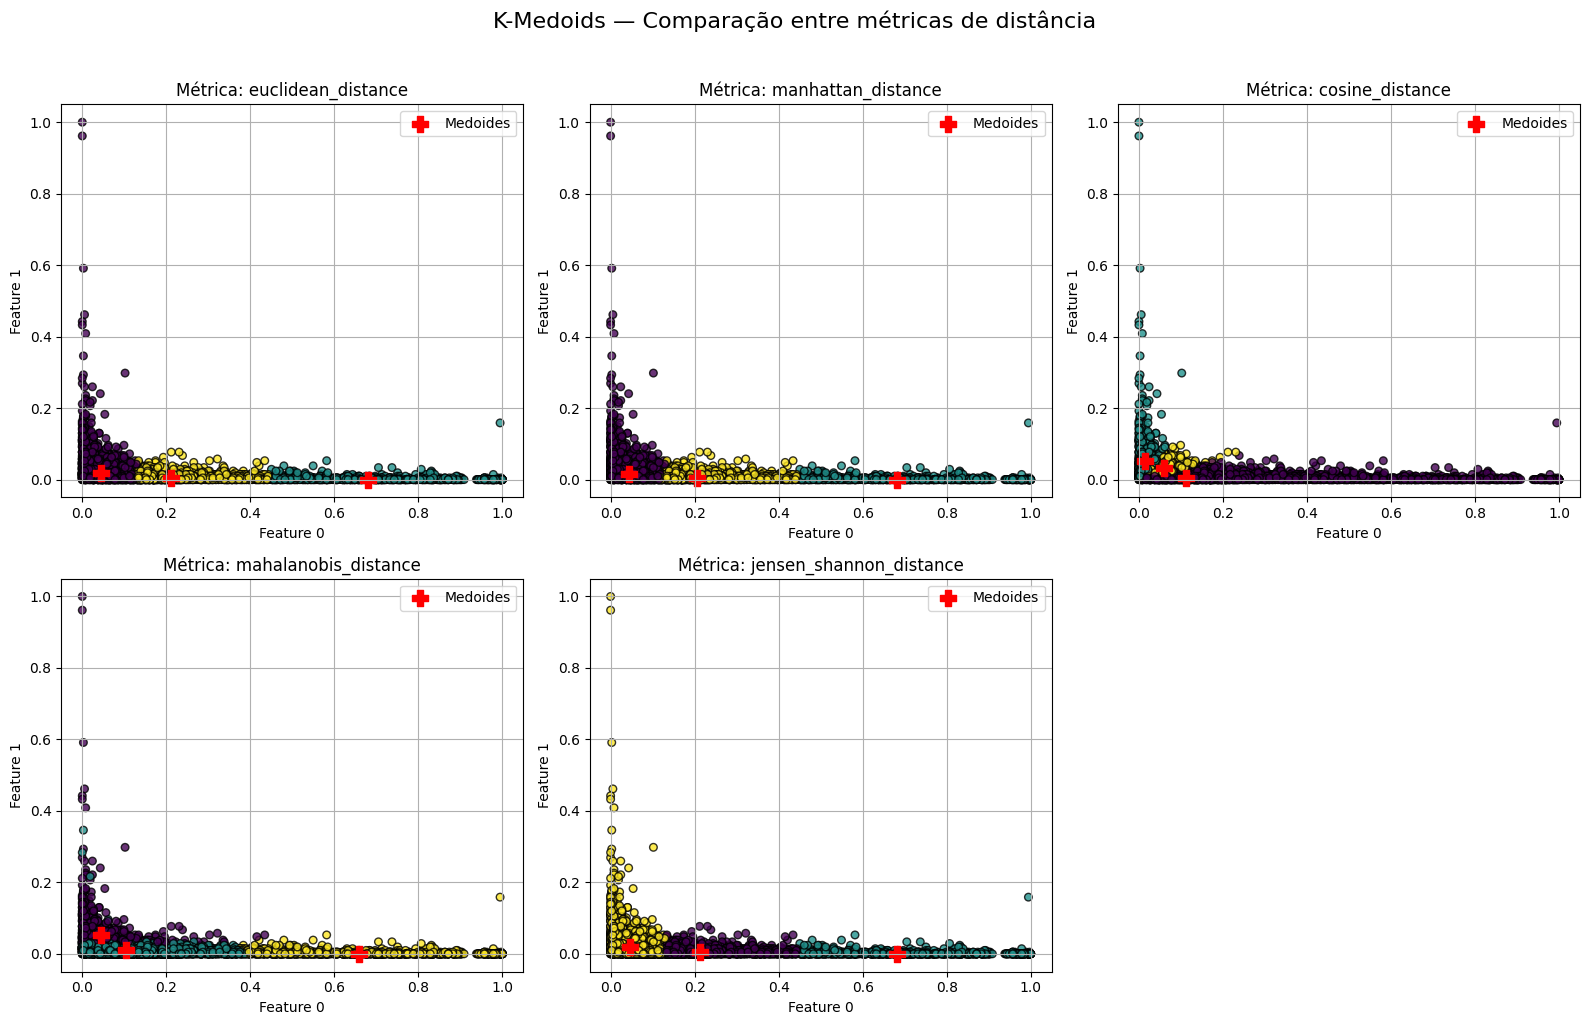

In [100]:
plot_algorithm_all_metrics(plots_kmedoids, "K-Medoids", x_index=0, y_index=1)

In [101]:
#results_kmedoids.pop()
df_results_kmedoids = pd.DataFrame(results_kmedoids)
df_results_kmedoids

,algorithm,internal_metric,n_clusters_found,runtime_sec,sse_euclidean,silhouette,davies_bouldin,calinski_harabasz
0,KMedoids,euclidean_distance,3,181.191048,47.547266,0.560215,0.584173,12520.997170
1,KMedoids,manhattan_distance,3,486.746579,47.777488,0.557401,0.586471,12450.218661
2,KMedoids,cosine_distance,3,610.247570,247.505290,-0.104145,1.386107,654.249311
3,KMedoids,mahalanobis_distance,3,317.924402,69.843137,0.269909,1.162687,7832.020549
4,KMedoids,jensen_shannon_distance,3,202.691306,47.547266,0.560215,0.584173,12520.997170


### Algoritmo: DBSCAN

In [102]:
results_dbscan = []
plots_dbscan = {}
# instaciando o DBSCAN
for metric_name in metrics:
    dbscan = DBSCAN(eps=0.3, min_samples=10, metric=metric_name)
    t0 = time()
    dbscan.fit(X)
    runtime_dbscan = time() - t0
    labels_dbscan = dbscan.labels_
    results_dbscan.append(calculate_clustering_metrics(algorithm_name="DBSCAN", metric_name=metric_name, runtime=runtime_dbscan, X=X, labels=labels_dbscan))
    plots_dbscan[metric_name] = {
        "X": X,
        "labels": labels_dbscan,
        "model": dbscan
    }


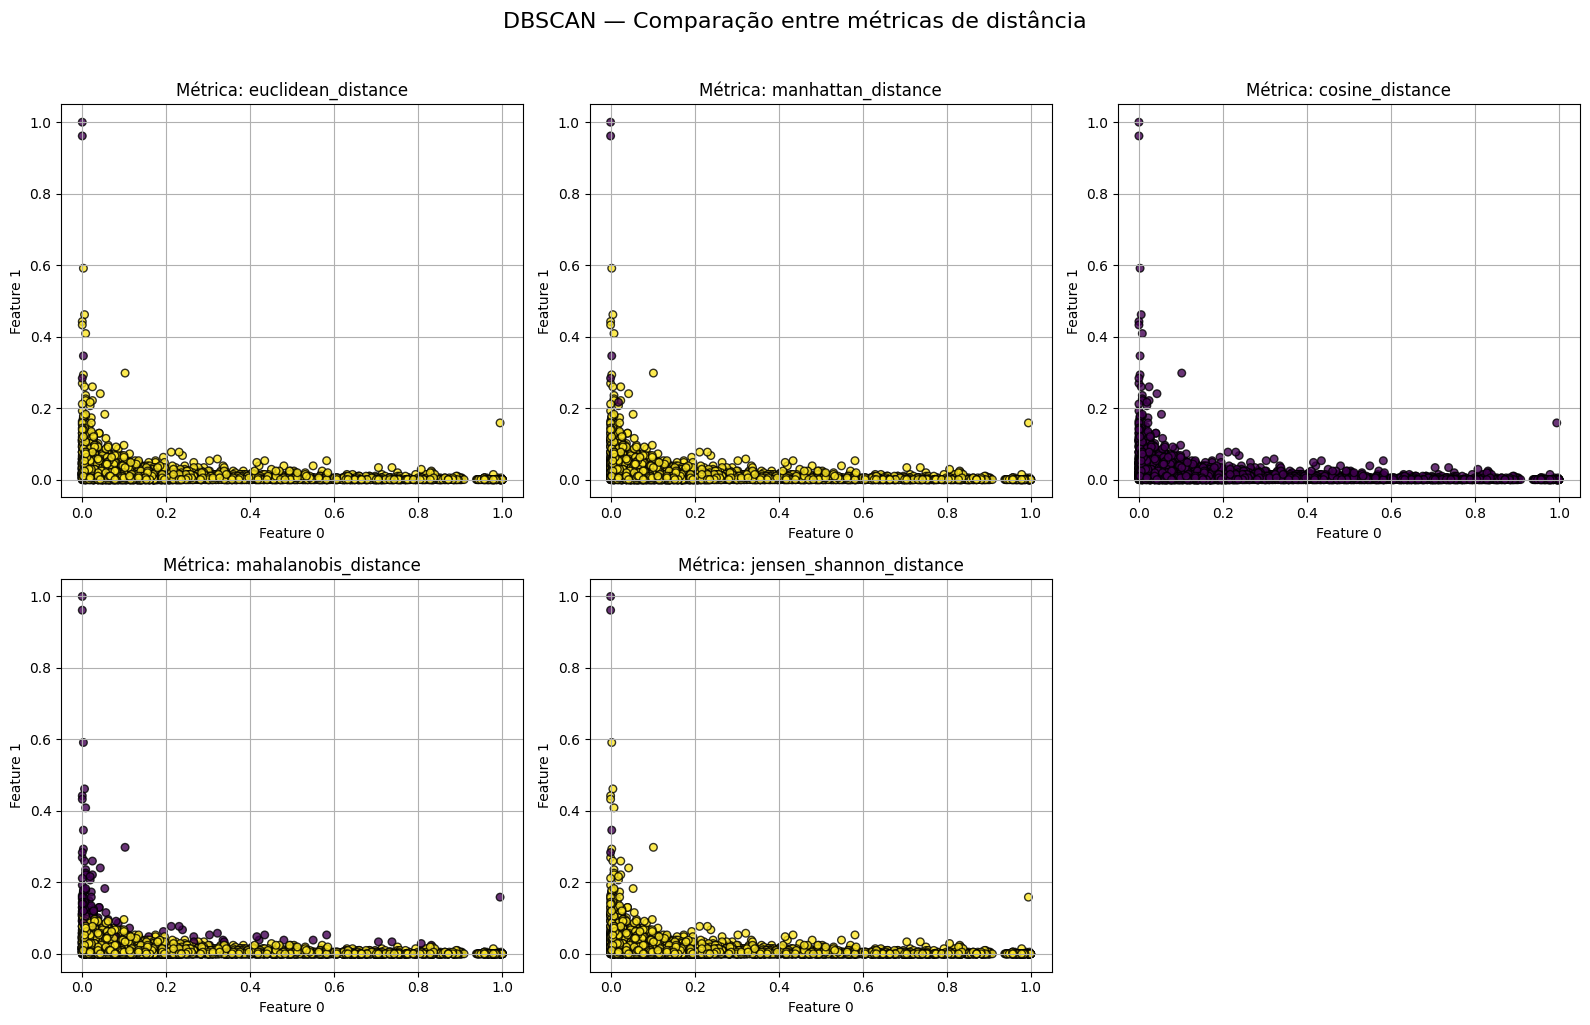

In [103]:
plot_algorithm_all_metrics(plots_dbscan, "DBSCAN", x_index=0, y_index=1)

In [104]:
#results_dbscan.pop()
df_results_dbscan = pd.DataFrame(results_dbscan)
df_results_dbscan

,algorithm,internal_metric,n_clusters_found,runtime_sec,sse_euclidean,silhouette,davies_bouldin,calinski_harabasz
0,DBSCAN,euclidean_distance,1,127.851271,317.827957,0.740208,0.749337,46.778244
1,DBSCAN,manhattan_distance,1,156.871777,316.849666,0.711051,0.818397,54.579581
2,DBSCAN,cosine_distance,1,282.203709,322.213555,NaN,NaN,NaN
3,DBSCAN,mahalanobis_distance,1,158.377906,304.242199,0.169869,2.173115,77.856214
4,DBSCAN,jensen_shannon_distance,1,126.102017,317.827957,0.740208,0.749337,46.778244


### Algoritmo: EM

In [ ]:
results_em = []
plots_em = {}
# instaciando the Expectation Maximization
for metric_name in metrics:
    em = ExpectationMaximization(n_clusters=3, max_iterations=7000, metric_name=metric_name)
    t0 = time()
    em.fit(X)
    runtime_em = time() - t0
    labels_em = em.labels_
    results_em.append(calculate_clustering_metrics(algorithm_name="Expectation Maximization", metric_name=metric_name, runtime=runtime_em, X=X, labels=labels_em))
    plots_em[metric_name] = {
        "X": X,
        "labels": labels_em,
        "model": em
    }

/root/jane-oliveira/tcc-git/clustering-client-segmentation-tcc/src/expectationmaximization.py:69: UserWarning: ExpectationMaximization: com métricas diferentes de 'mahalanobis_distance', o algoritmo deixa de ser um GMM probabilisticamente consistente e passa a ser uma variante experimental de soft-clustering baseada em distância.
  warnings.warn(
/root/jane-oliveira/tcc-git/clustering-client-segmentation-tcc/src/expectationmaximization.py:69: UserWarning: ExpectationMaximization: com métricas diferentes de 'mahalanobis_distance', o algoritmo deixa de ser um GMM probabilisticamente consistente e passa a ser uma variante experimental de soft-clustering baseada em distância.
  warnings.warn(
/root/jane-oliveira/tcc-git/clustering-client-segmentation-tcc/src/expectationmaximization.py:69: UserWarning: ExpectationMaximization: com métricas diferentes de 'mahalanobis_distance', o algoritmo deixa de ser um GMM probabilisticamente consistente e passa a ser uma variante experimental de soft-clu

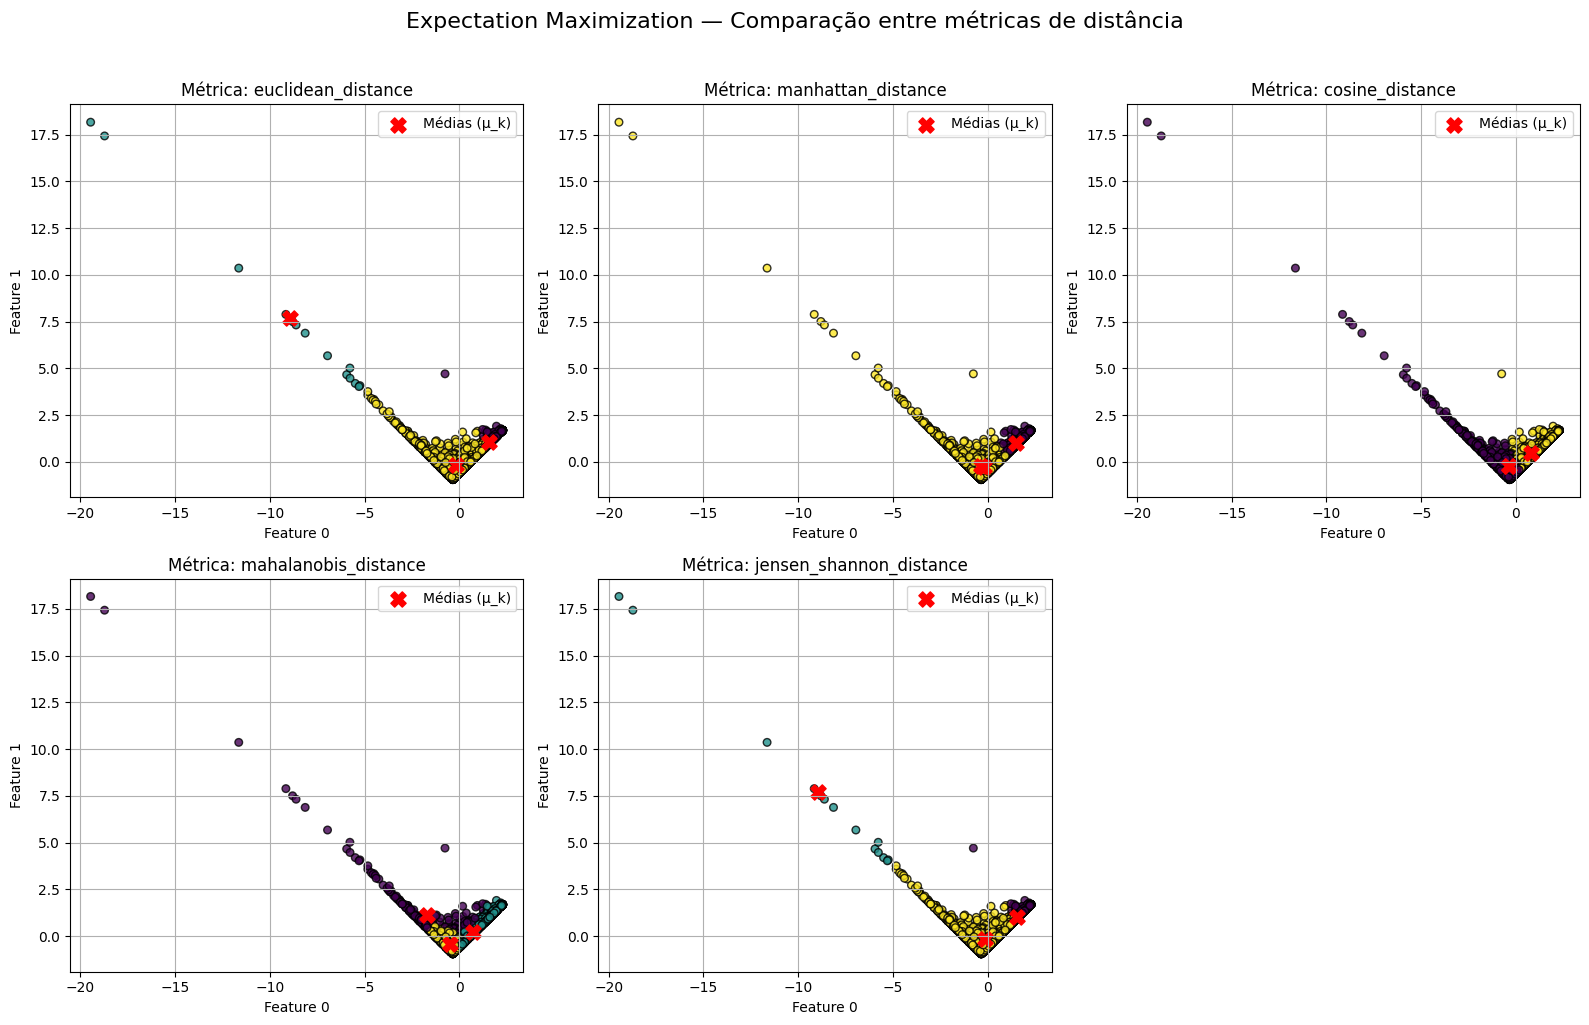

In [106]:
plot_algorithm_all_metrics(plots_em, "Expectation Maximization", x_index=0, y_index=1)

In [107]:
#results_em.pop()
df_results_em = pd.DataFrame(results_em)
df_results_em

,algorithm,internal_metric,n_clusters_found,runtime_sec,sse_euclidean,silhouette,davies_bouldin,calinski_harabasz
0,Expectation Maximization,euclidean_distance,3,17.699475,4453.277336,0.540156,0.453131,2055.284385
1,Expectation Maximization,manhattan_distance,2,67.237724,5314.520304,0.585438,0.508460,2742.557208
2,Expectation Maximization,cosine_distance,2,2.264713,5293.984969,0.527911,0.734870,2770.014886
3,Expectation Maximization,mahalanobis_distance,3,0.102362,4623.466150,0.420865,0.926759,1899.844583
4,Expectation Maximization,jensen_shannon_distance,3,32.440015,4453.277336,0.540156,0.453131,2055.284385


### Algoritmo: Ward

In [ ]:
results_ward = []
plots_ward = {}
# instaciando the Ward Method
for metric_name in metrics:
    ward = WardMethod(k=3, metric=metric_name)
    t0 = time()
    labels_ward = ward.fit_predict(X)
    runtime_ward = time() - t0
    results_ward.append(calculate_clustering_metrics(algorithm_name="Ward Method", metric_name=metric_name, runtime=runtime_ward, X=X, labels=labels_ward))
    plots_ward[metric_name] = {
        "X": X,
        "labels": labels_ward,
        "model": ward
    }

In [ ]:
plot_algorithm_all_metrics(plots_ward, "Ward Method", x_index=0, y_index=1)

In [ ]:
#results_ward.pop()
df_results_ward = pd.DataFrame(results_ward)
df_results_ward
# Plotar dendrograma truncado (últimos merges)
ward.plot_dendrogram(truncate_mode='lastp', p=10)